# California House Price Predictor

**This notebook contains:** an overview of the dataset, visualization, the process of formatting the data, training, and identifying the best machine learning model for California house prices, based on the 1990s California census.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import FunctionTransformer, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.pipeline import Pipeline

### Loading dataset

In [2]:
housing = pd.read_csv('./housing.csv')

### Exploring dataset

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [4]:
housing.shape

(20640, 10)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

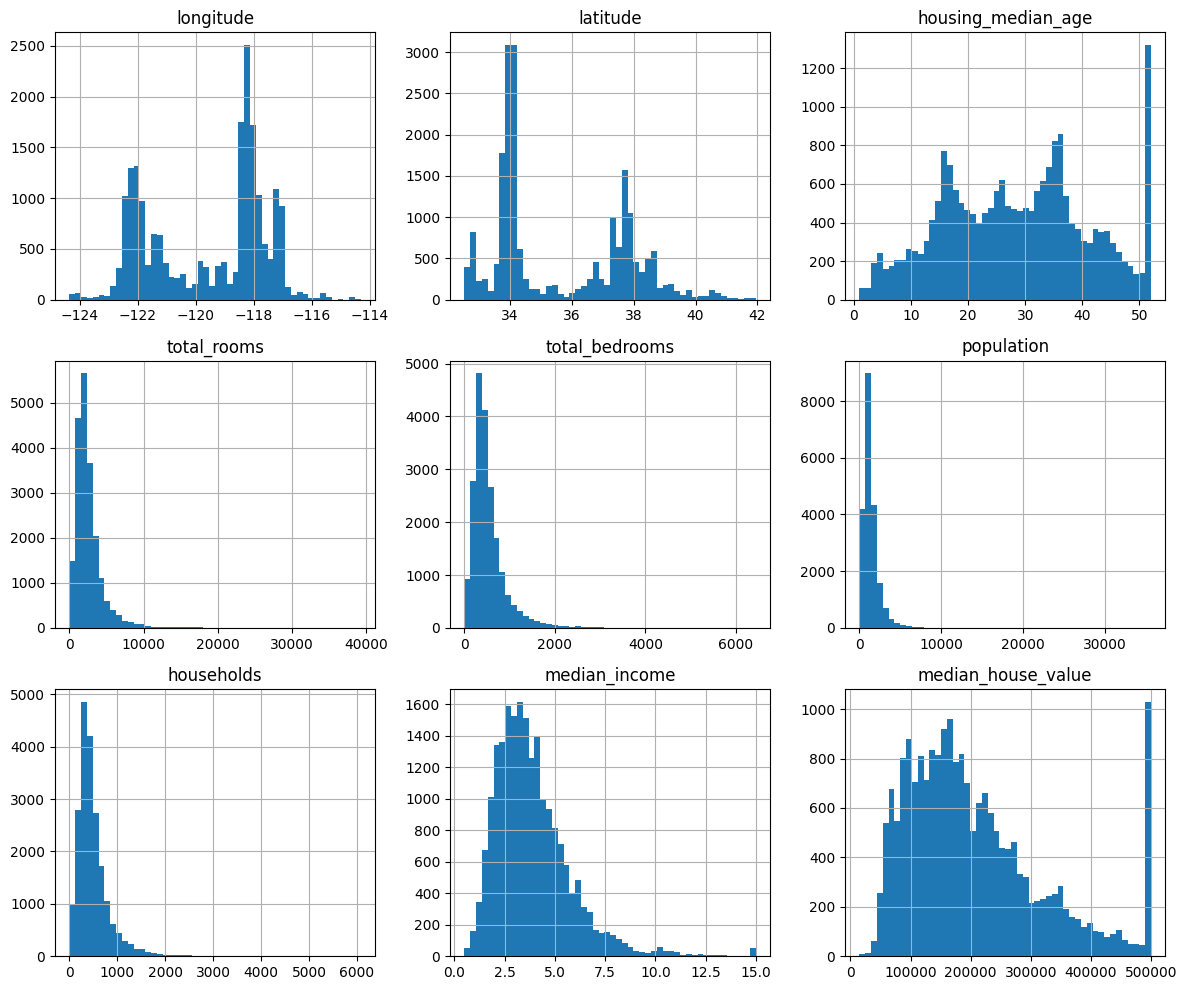

In [8]:
plt.rc('axes', titlesize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12,10))
plt.tight_layout()
plt.show()

### Creating new feature

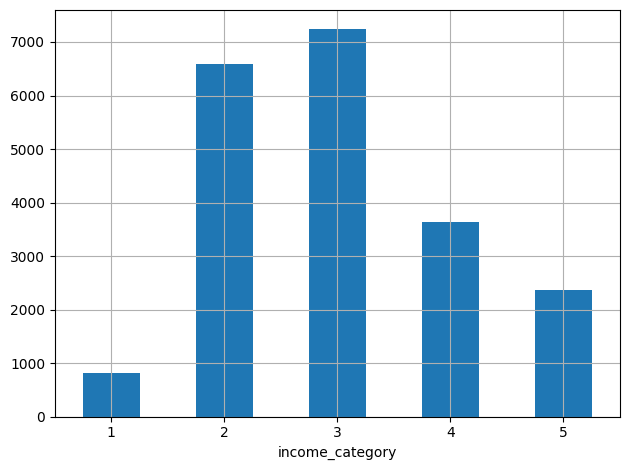

In [9]:
housing['income_category'] = pd.cut(
    housing['median_income'],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5]
)

categories_count = housing['income_category'].value_counts().sort_index()
categories_count.plot.bar(grid=True, rot=0)
plt.tight_layout()
plt.show()

### Spliting data into two subsets

In [10]:
train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_category'], random_state=42)

def income_category_proportions(data):
    return data['income_category'].value_counts() / len(data)

compare = pd.DataFrame(
    {
        'Overall %': income_category_proportions(housing) * 100,
        'Test set %': income_category_proportions(test_set) * 100
    }
).sort_index()

compare.index.name = 'Income category'
compare['Difference in pp'] = (compare['Overall %'] - compare['Test set %'])

compare.round(2)

,Overall %,Test set %,Difference in pp
Income category,,,
1,3.98,4.00,-0.01
2,31.88,31.88,0.00
3,35.06,35.05,0.00
4,17.63,17.64,-0.00
5,11.44,11.43,0.01


### Removing new feature and moving test set aside

In [11]:
if 'income_category' in train_set.columns:
    for set in (train_set, test_set):
        set.drop('income_category', axis=1, inplace=True)

housing = train_set.copy()

### Visualizing geographical data

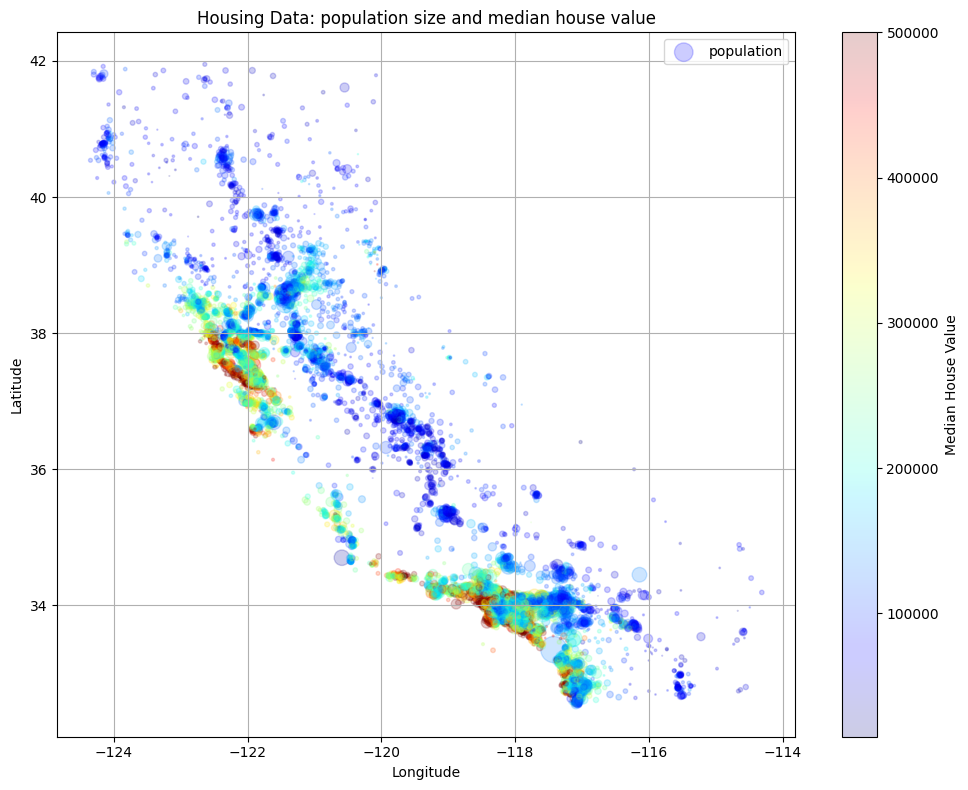

In [12]:
plt.figure(figsize=(10,8))

scatter = plt.scatter(
    x=housing['longitude'],
    y=housing['latitude'],
    s=housing['population'] / 100,
    c=housing['median_house_value'],
    cmap='jet',
    alpha=0.2,
    label='population'
)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid('True')
plt.colorbar(scatter, label='Median House Value')
plt.legend()
plt.title('Housing Data: population size and median house value')
plt.tight_layout()
plt.show()

### Correlation between data

In [13]:
correlation_matrix = housing.select_dtypes(include=['number']).corr()
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [14]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

correlation_matrix = housing.select_dtypes(include=['number']).corr()
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ratio       -0.259952
Name: median_house_value, dtype: float64

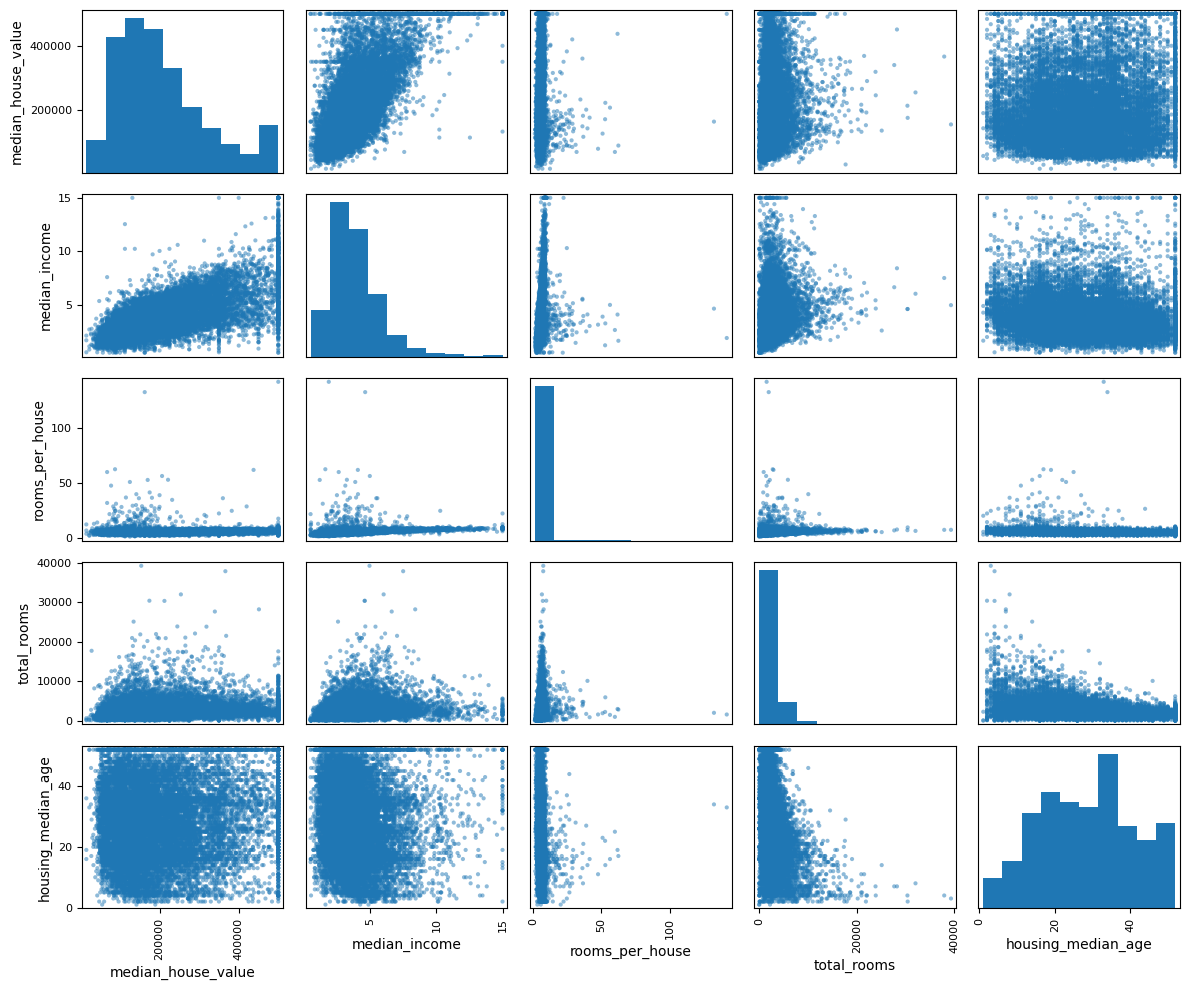

In [15]:
features = ['median_house_value', 'median_income', 'rooms_per_house', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[features], figsize=(12,10), diagonal='hist')
plt.tight_layout()
plt.show()

### Prepering data for Machine learning

In [16]:
housing = train_set.drop('median_house_value', axis=1)
housing_labels = train_set['median_house_value'].copy()

### Data preprocessing pipeline

In [17]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))   
],
remainder=default_num_pipeline)

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared


array([[-0.12112176,  0.01739526,  0.00622264, ..., -0.94135046,
         1.34743822,  0.02756357],
       [-0.81086696,  0.56925554, -0.04081077, ...,  1.17178212,
        -1.19243966, -1.72201763],
       [-0.33827252, -0.01802432, -0.07537122, ...,  0.26758118,
        -0.1259716 ,  1.22045984],
       ...,
       [ 0.32286937, -0.5092404 , -0.03743619, ..., -1.5707942 ,
         1.31001828,  1.53856552],
       [-0.45702273,  0.32814891, -0.05915604, ..., -1.56080303,
         1.2492109 , -1.1653327 ],
       [-0.12169672,  0.01407228,  0.00657083, ..., -1.28105026,
         2.02567448, -0.13148926]], shape=(16512, 16))

### Selecting and training model

In [18]:
lin_reg = make_pipeline(preprocessing, LinearRegression())

lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     73619.351005
std       8211.643158
min      66632.110641
25%      70285.398497
50%      71946.079795
75%      73561.811692
max      95865.148429
dtype: float64

In [19]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     71079.810413
std       2882.695407
min      67866.362421
25%      69420.412556
50%      70168.763110
75%      72112.508005
max      77768.311676
dtype: float64

In [20]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forests_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(forests_rmses).describe()

count       10.000000
mean     50387.089527
std       2348.804935
min      47012.039310
25%      48714.298717
50%      50655.263189
75%      51878.210276
max      54145.542197
dtype: float64

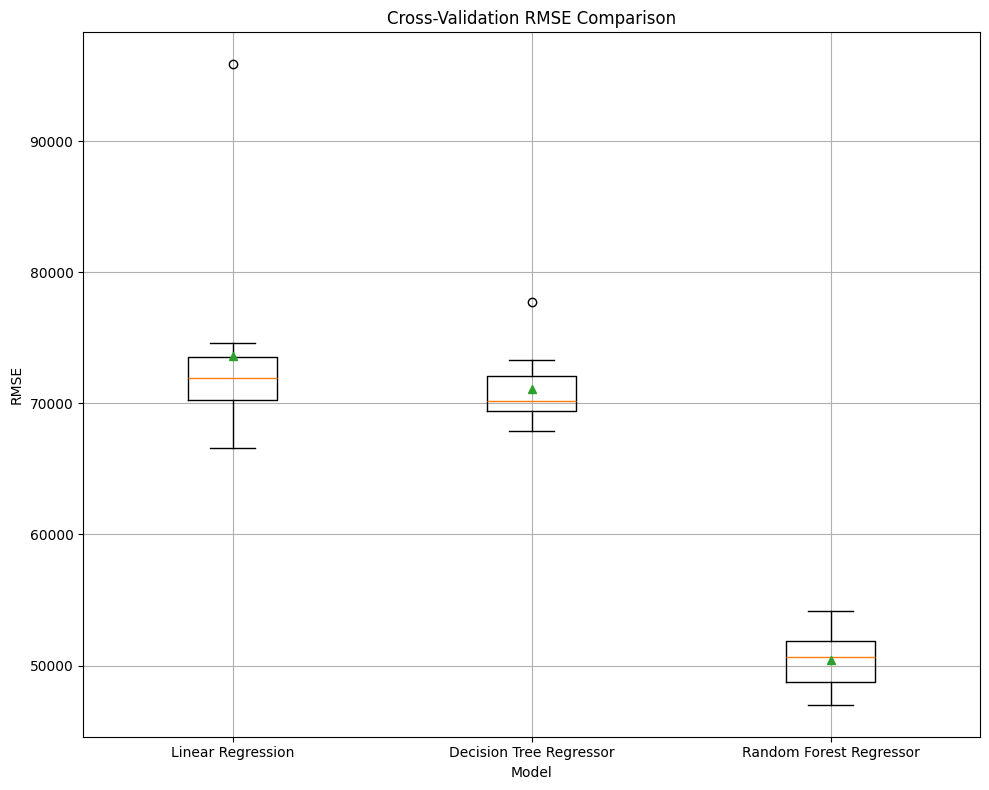

In [ ]:
models_name = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor']
results = [lin_rmses, tree_rmses, forests_rmses]

plt.figure(figsize=(10,8))
plt.boxplot(results, tick_labels=models_name, showmeans=True)
plt.title('Cross-Validation RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42)),
])

param_distribs = {
    'random_forest__max_features': randint(low=2, high=20)
}

rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42)

rnd_search.fit(housing, housing_labels)
final_model = rnd_search.best_estimator_

In [ ]:
X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value'].copy()

final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
final_rmse

46864.46982480885